# Train MLP for MNIST Dataset!!!

In [1]:
import typing as tp
import time

import torch # [for torch.tensor(...) {instead of numpy}]
import torchvision # for mnist dataset
from torch import Tensor # for type hints
import matplotlib.pyplot as plt
DEVICE = torch.device("cpu")
g = torch.Generator(device=DEVICE).manual_seed(42)

## Get Dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
train_data = trainset.data.float()
y_train = trainset.targets

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
X_VAL = testset.data.float()
y_val = testset.targets

In [3]:
X_train = train_data.reshape((-1, 28*28))/255.
X_val = X_VAL.reshape((-1, 28*28))/255.

num_classes = torch.unique(y_train)
print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}\nX_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")

X_train.shape = torch.Size([60000, 784])
y_train.shape = torch.Size([60000])
X_val.shape = torch.Size([10000, 784])
y_val.shape = torch.Size([10000])


## MLP-TODO:
* Initialize parameters
* Make minibatches
* Define Activation functions and Loss function
* Forward Pass
* Backward Pass: Compute grads (Will be using torch's autograd as you are a BackpropWhiz, see `nn.ipynb` notebook if you haven't)
* Update parameters using gradient descent
* `for` loop for epochs

### Initialize parameters

In [4]:
def initialize_params(size:tp.Sequence): # [784, 512, 128, 10]
    """returns `parmas` (parameters)"""
    # input layer
    w1 = torch.randn((size[0], size[1]), generator=g, device=DEVICE)*(2./size[0])**0.5
    b1 = torch.randn(size[1], generator=g, device=DEVICE)*0.01

    # hidden layer 1
    w2 = torch.randn((size[1], size[2]), generator=g, device=DEVICE)*(2./size[1])**0.5
    b2 = torch.randn(size[2], generator=g, device=DEVICE)*0.009

    # output layer
    w3 = torch.randn((size[2], size[3]), generator=g, device=DEVICE)*(2./size[2])**0.5
    b3 = torch.randn(size[3], generator=g, device=DEVICE)*0.0109

    params:list[Tensor] = [w1, b1, w2, b2, w3, b3]
    print("Number of parameters in the network:", sum(p.nelement() for p in params))
    
    for p in params:
        p.requires_grad = True
    return params

### Make minibatches

In [5]:
def shuffle(X:Tensor, y:Tensor): # (m, ...), (m, ...)
    """returns X, y (but shuffled)"""
    idx = torch.randperm(X.shape[0])
    return X[idx].to(DEVICE), y[idx].to(DEVICE)

In [6]:
def batch(X:Tensor, y:Tensor, batch_size:int):
    """returns X, y (batched form of inputs X and y)"""
    num_features = X.shape[-1]
    rem_idx = None
    if len(X)%batch_size != 0:
        rem_idx = -(len(X)%batch_size)
    X, y = shuffle(X, y) # (m, 784), (m, 10)
    X, y = X[:rem_idx], y[:rem_idx]
    X, y = X[None].reshape((-1, batch_size, num_features)), y[None].reshape((-1, batch_size))
    return X.to(device=DEVICE), y.to(device=DEVICE) # (m//B, B, 784), (m//B, B, 10)

## Dropout

In [7]:
def dropout(x:Tensor, keep_prob:float, training:bool):
    if keep_prob == 1.0 or not training:
        return x
    if keep_prob == 0.0:
        return torch.zeros_like(x, device=x.device)
    
    mask = torch.bernoulli(torch.full_like(x, keep_prob, device=x.device), generator=g).bool()
    return torch.where(mask, x/keep_prob, 0.0)

### Define Activation function and Cross Entropy

In [8]:
def relu(x:Tensor):
    return x * (x > 0)

In [9]:
def softmax(logits:Tensor, axis:int=-1):
    logits = logits - logits.max(axis, keepdim=True).values # (B, 10)
    exp = logits.exp() # (B, 10)
    exp_sum = exp.sum(axis, keepdim=True) # (B, 1)
    return exp/exp_sum # (B, 10)

In [10]:
def CrossEntropy(y_true:Tensor, y_proba:Tensor):
    log_probs = y_proba.log() # (B, num_classes)
    L = -log_probs[range(len(y_proba)), y_true].mean() # ()
    return L # ()

In [11]:
def dropout(x:Tensor, keep_prob:float, training:bool):
    if keep_prob == 1.0 or not training:
        return x
    if keep_prob == 0.0:
        return torch.zeros_like(x, device=x.device)
    
    mask = torch.bernoulli(torch.full_like(x, keep_prob, device=x.device), generator=g).bool()
    return torch.where(mask, x/keep_prob, 0.0)

### Forward Propagation

In [12]:
def forwardprop(
    x:Tensor, 
    y:Tensor, 
    params:list[Tensor],
    training:bool
): # [784, 512, 128, 10]
    """ returns `loss(x, y)`, `y_proba`, `params`"""
    w1, b1, w2, b2, w3, b3 = params
    
    z1 = x.float().to(DEVICE) @ w1 + b1 # (B, 512) <== (B, 784) @ (784, 512) + (512)
    z1 = dropout(z1, keep_prob=0.8, training=training)
    h1 = relu(z1) # (B, 512)

    z2 = h1 @ w2 + b2 # (B, 128) <== (B, 512) @ (512, 128)
    z2 = dropout(z2, keep_prob=0.5, training=training)
    h2 = relu(z2) # (B, 128)

    logits = h2 @ w3 + b3 # (B, 10) <== (B, 128) @ (128, 10)
    y_proba = softmax(logits) # (B, 10)
    loss = CrossEntropy(y, y_proba) # ()

    params = [w1, b1, w2, b2, w3, b3]
    return loss, y_proba, params #, activations

### BackPropagation
* Skipping this as you are a BackpropWhiz! (See nn.ipynb for that if you haven't)

### Gradient Descent

In [13]:
def zero_grads(params:list[Tensor]):
    for param in params:
        param.grad = None

def sgd(lr:float, params:list[Tensor]):
    """returns updated `params` (parameters)"""
    for param in params:
        param.data -= lr * param.grad
    return params

### Train Loop

In [14]:
def get_accuracy(y_true:Tensor, y_probs:Tensor):
    y_pred = torch.argmax(y_probs, axis=-1).cpu()
    return (y_true.cpu()==y_pred).float().sum()/len(y_true)

In [15]:
def train_loop(
        lr,
        epochs,
        train_ds, 
        val_ds,
        batch_size = 32,
        val_interval = 2
    ):
    X_train, y_train = train_ds
    XB_train, yB_train = batch(X_train, y_train, batch_size); m_B = XB_train.shape[0]
    X_val, y_val = val_ds
    
    # initialize parameters
    size = [784, 512, 128, 10]
    params = initialize_params(size)

    # For loop for epochs and steps
    plotlosses = []; t0 = time.time()
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}", end=" | ")
        losses = 0
        XB_train, yB_train = shuffle(XB_train, yB_train)
        for step in range(m_B):
            # Get batch
            X_batch, y_batch = XB_train[step].to(DEVICE), yB_train[step].to(DEVICE)
            # Forward pass
            loss, y_proba, params = forwardprop(
                X_batch, y_batch, params, training=True
            ); losses += loss
            # Zero grads
            zero_grads(params)
            # Backward pass
            loss.backward()
            # Update params
            params = sgd(lr, params)
            # list of losses for plotting
            plotlosses.append(loss.item())
        # time
        t1 = time.time()
        dt = t1 - t0; t0 = t1
        print(f"Loss: {(losses/m_B):.4f}", end=f" | Avg time per step: {(dt*1000/m_B):.2f} ms | ")
        print(f"Validation Loss: {forwardprop(X_val, y_val, params, False)[0]:.4f} |" if (epoch%val_interval==0 or epoch==epochs-1) else "")
    
    train_metrics = forwardprop(X_train, y_train, params, False)
    val_metrics = forwardprop(X_val, y_val, params, False)
    print(f"Train Accuracy:      {get_accuracy(y_train, train_metrics[1]):.4f} | Train Loss: {train_metrics[0]:.4f} |")
    print(f"Validation Accuracy: {get_accuracy(y_val, val_metrics[1]):.4f} | Validation Loss: {val_metrics[0]:.4f} |")
    return params, plotlosses

Number of parameters in the network: 468874
Epoch: 1/30 | Loss: 0.7782 | Avg time per step: 0.70 ms | Validation Loss: 0.3083 |
Epoch: 2/30 | Loss: 0.4070 | Avg time per step: 0.68 ms | Validation Loss: 0.2348 |
Epoch: 3/30 | Loss: 0.3233 | Avg time per step: 0.68 ms | Validation Loss: 0.1983 |
Epoch: 4/30 | Loss: 0.2772 | Avg time per step: 0.68 ms | Validation Loss: 0.1727 |
Epoch: 5/30 | Loss: 0.2426 | Avg time per step: 0.67 ms | Validation Loss: 0.1529 |
Epoch: 6/30 | Loss: 0.2197 | Avg time per step: 0.68 ms | Validation Loss: 0.1422 |
Epoch: 7/30 | Loss: 0.2023 | Avg time per step: 0.69 ms | Validation Loss: 0.1288 |
Epoch: 8/30 | Loss: 0.1833 | Avg time per step: 0.68 ms | Validation Loss: 0.1207 |
Epoch: 9/30 | Loss: 0.1719 | Avg time per step: 0.68 ms | Validation Loss: 0.1129 |
Epoch: 10/30 | Loss: 0.1601 | Avg time per step: 0.67 ms | Validation Loss: 0.1099 |
Epoch: 11/30 | Loss: 0.1507 | Avg time per step: 0.68 ms | Validation Loss: 0.1025 |
Epoch: 12/30 | Loss: 0.1405 | 

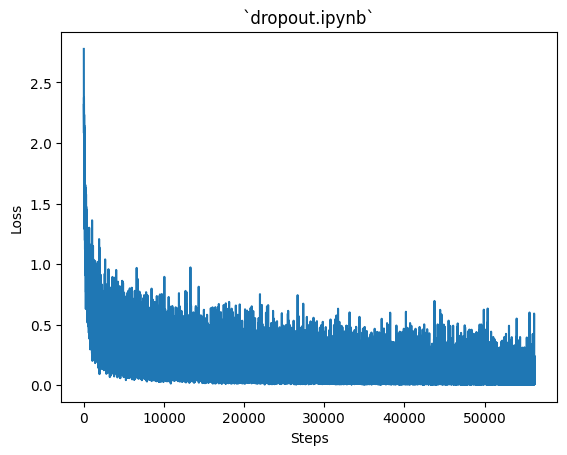

In [16]:
params, losses = train_loop(0.01, 30, [X_train, y_train], [X_val, y_val], val_interval=1)
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("`dropout.ipynb`")
plt.show()

* Step at which we get the best Val Loss:

  `Epoch: 14/30 | Loss: 0.0050 | Avg time per step: 0.73 ms | Validation Loss: 0.0772 |`

## Make Predictions

In [17]:
def predict(img_idx):
    img = torch.tensor(X_VAL[img_idx].tolist())[0] # (28, 28)
    y_true = y_val[img_idx].cpu()
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    y_pred = torch.argmax(forwardprop(img.reshape((1, -1)), y_true, params)[1], axis=-1).cpu()
    print(f"True Digit: {y_true}")
    print(f"Predicted Digit: {y_pred}")
    plt.show()

TypeError: forwardprop() missing 1 required positional argument: 'training'

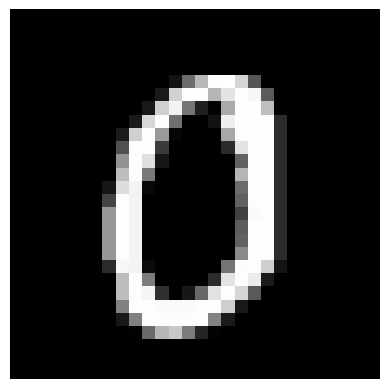

In [18]:
for _ in range(100):
    predict(torch.randint(10_000, (1,)))

In [ ]:
# def dropout(x:Tensor, keep_prob:float, training:bool):
#     if keep_prob == 1.0 or not training:
#         return x
#     if keep_prob == 0.0:
#         return torch.zeros_like(x, device=x.device)
    
#     mask = torch.bernoulli(torch.full_like(x, keep_prob, device=x.device), generator=g).bool()
#     return torch.where(mask, x/keep_prob, 0.0)

# def assert_func(exp, statememt):
#     assert exp, statememt

# torch_dropout = torch.nn.Dropout(0.5)

# def check_expectation_dropout(shape:tuple, keep_prob:float=0.5, torch_func=False):
#     x = torch.rand(shape, dtype=torch.float32) # (B, D)
#     if torch_func:
#         drop_x = torch.stack([torch_dropout(xi) for xi in x], dim=0)
#     else:
#         drop_x = torch.stack([dropout(xi, keep_prob, training=True) for xi in x], dim=0)
#     expect_x, expect_dropx = x.mean(0), drop_x.mean(0)
#     print("(expect_x-expect_dropx).abs().mean(0)", (expect_x-expect_dropx).abs().mean(0), sep="\n")
#     return x, drop_x

# x, dx = check_expectation_dropout((40000, 1000), 0.1, torch_func=True)
# x.shape, dx.shape

# x, dx = check_expectation_dropout((40000, 1000), 0.1, torch_func=False)
# x.shape, dx.shape